In [2]:
import pandas as pd
import numpy as np
from influxdb import InfluxDBClient
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
from dateutil import tz

sns.set(style="whitegrid")
sns.set(font_scale=0.7)

# TODO

- 2d and 3d PCA mapping
- heatmap of coeff

In [12]:
class InfluxDB:
    def __init__(self, url: str, port: int, username: str, password: str,
                 basestations: list, beacon: str, classification: str,
                 measurement: str = "distance",
                 startdatetime: str = None, enddatetime: str = None):
        self.client = InfluxDBClient(url, port, username, password)
        self.basestations = basestations
        self.beacon = beacon
        self.classification = classification
        self.measurement = measurement
        self.timefilter = '1=1'
        self.timefilter += f"\n\t\tAND time >= '{InfluxDB.convert_to_rfc3339(startdatetime)}'" if startdatetime else ''
        self.timefilter += f"\n\t\tAND time <= '{InfluxDB.convert_to_rfc3339(enddatetime)}'" if enddatetime else ''

    @property
    def df_basestation_beacon_values(self):
        where = ''.join([f"\n\t\t    OR entity_id = 'mqtt_{self.beacon}_{basestation}_{self.measurement}'" for basestation in self.basestations])
        query = f'''
            SELECT entity_id as basestation, value as distance
            FROM homeassistant.autogen.m
            WHERE {self.timefilter}
                AND (
                    1<>1 {where}
                )
        '''
        df = pd.DataFrame(self.client.query(query).get_points())
        df.time = pd.to_datetime(df.time)
        return df

    @property
    def df_classifications(self):
        query = f'''
            SELECT state as y
            FROM homeassistant.autogen.state
            WHERE {self.timefilter}
                AND entity_id = '{self.classification}'
        '''
        df = pd.DataFrame(self.client.query(query).get_points())
        df.time = pd.to_datetime(df.time)
        return df

    def get_Xy(self):
        self.df = (
            pd.concat([self.df_basestation_beacon_values, self.df_classifications], axis=0)
            .pivot(index=['time', 'y'], columns='basestation', values='distance')
            .fillna(method='ffill')
            .reset_index('y')
            .fillna(method='ffill')
            .drop(np.nan, axis=1)
            .dropna()
            .query('y != "None"')
        )
        self.X = self.df.drop('y', axis=1)
        self.y = self.df.y
        return self.X, self.y

    def show_basestation_strength(self):
        fig, ax = plt.subplots(3, figsize=(10, 3), sharex=True, sharey=True)
        data = self.df_basestation_beacon_values
        for i, basestation in enumerate(data.basestation.unique()):
            sns.lineplot(
                data=data.loc[data.basestation == basestation],
                x='time', y='distance',
                linewidth=0.5, ax=ax[i]
            ).set_title(basestation)
        plt.show()

    @staticmethod
    def convert_to_rfc3339(date_string):
        dt = parse(date_string)
        dt = dt.astimezone(tz.UTC)
        return dt.strftime('%Y-%m-%dT%H:%M:%SZ')

basestations = ['office', 'playroom', 'livingroom', 'kitchen', 'bedroomjk', 'bedroomcc']
beacon = 'iphonejd'

influx = InfluxDB(
    url='192.168.50.134',
    port=8086,
    username='homeassistant',
    password='homeassistant',
    basestations=basestations,
    beacon=beacon,
    classification='jd_iphone_room_training_data',
    measurement='distance',
    startdatetime='2023-07-20T16:00:00',
)

X, y = influx.get_Xy()
print(y.value_counts())

y
LivingRoom    757
Playroom      691
Office        668
BedroomJK     647
Kitchen       640
BedroomCC     636
Hallway0      635
Hallway1      624
Hallway2      595
BedroomS      581
DiningRoom    563
Name: count, dtype: int64


<Axes: ylabel='basestation'>

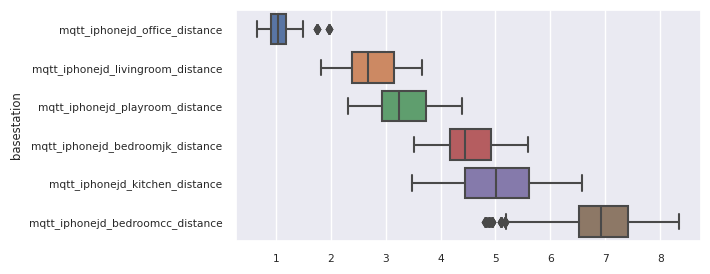

In [13]:
plt.figure(figsize=(6, 3))
data = X[y=='Office']
sns.boxplot(
    data=data,
    orient='h',
    order=data.mean().sort_values().index.tolist()
)

<Axes: xlabel='distance', ylabel='y'>

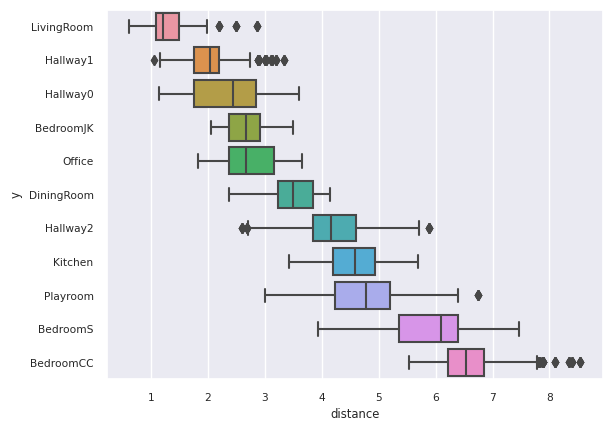

In [14]:
data = X[['mqtt_iphonejd_livingroom_distance']].join(y)
data.columns = ['distance', 'y']
sns.boxplot(data=data, x='distance', y='y', order=data.groupby('y').mean().sort_values(by='distance').index.tolist())

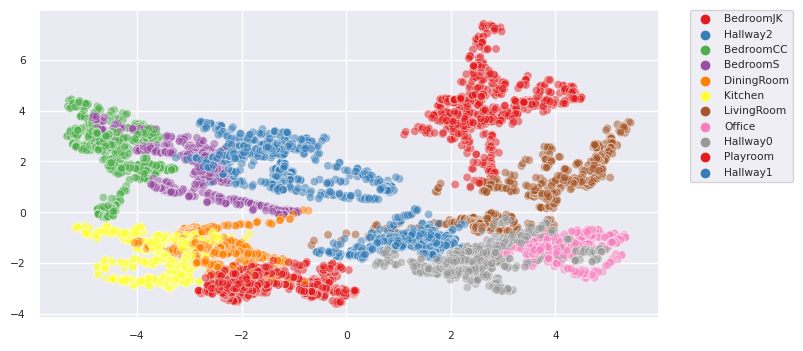

In [15]:
pca = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(8, 4))
sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=y, palette='Set1', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Cross-val scores:	0.88 0.06 [0.79 0.89 0.94]
Train-test train score:	0.9704377487208641
Train-test test score:	0.959659090909091
              precision    recall  f1-score   support

   BedroomCC       0.97      0.95      0.96       159
   BedroomJK       0.98      0.98      0.98       162
    BedroomS       0.88      0.97      0.92       145
  DiningRoom       0.85      0.98      0.91       141
    Hallway0       0.99      1.00      0.99       159
    Hallway1       0.95      0.96      0.96       156
    Hallway2       1.00      0.93      0.96       149
     Kitchen       1.00      0.86      0.92       160
  LivingRoom       0.97      0.95      0.96       189
      Office       0.99      0.99      0.99       167
    Playroom       0.99      0.99      0.99       173

    accuracy                           0.96      1760
   macro avg       0.96      0.96      0.96      1760
weighted avg       0.96      0.96      0.96      1760



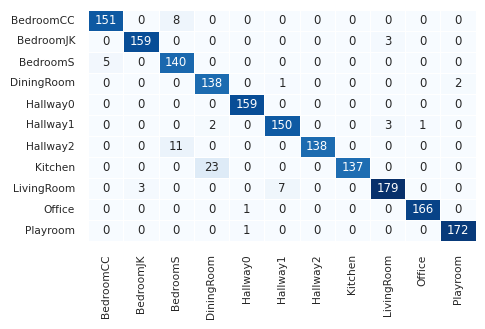

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [16]:
# Normalise
scaler = X.describe().loc[['mean', 'std']].T
X = (X - scaler['mean']) / scaler['std']

# Define model
lr = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', C=0.1, solver='lbfgs', multi_class='multinomial')

# Cross-validation
scores = cross_val_score(lr, X, y, cv=StratifiedKFold(n_splits=3))
print(f"Cross-val scores:\t{scores.mean().round(2)} {scores.std().round(2)} {scores.round(2)}")

# Train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
lr.fit(X_train, y_train)
print(f'Train-test train score:\t{lr.score(X_train, y_train)}')
print(f'Train-test test score:\t{lr.score(X_test, y_test)}')
y_pred = lr.predict(X_test)

# Train Test Metrics
print(classification_report(y_test, y_pred))
plt.figure(figsize=(5, 3))
sns.heatmap(
    data=confusion_matrix(y_test, y_pred),
    annot=True, fmt='d', cbar=False, square=False,
    linecolor='white', linewidths=0.5, cmap='Blues',
    xticklabels=lr.classes_,
    yticklabels=lr.classes_,
)
plt.show()

# Final model fit
lr.fit(X, y)

<Axes: >

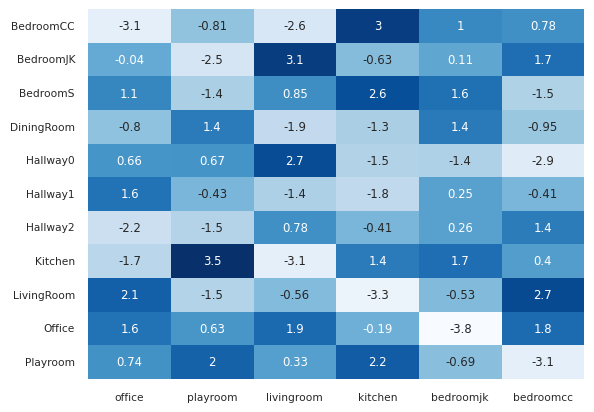

In [17]:
sns.heatmap(
    data=lr.coef_.round(2),
    annot=True,
    cbar=False,
    cmap='Blues',
    xticklabels=basestations,
    yticklabels=lr.classes_,
)

In [44]:
def write_yaml(coef, intercept, classes, feature_names, device, measurement):
    class_names = ", ".join([('\n' + 10*' ' if i % 6 == 0 else '') + f'"{c}"' for i, c in enumerate(lr.classes_)])
    x_variables = f"\n{8 * ' '}".join([
        f"{{% set x{i+1} = (states('sensor.{f.replace('distance', measurement)}') | float - {scaler.loc[f, 'mean']}) / {scaler.loc[f, 'std']} %}}"
        for i, f in enumerate(feature_names)
    ])
    logits = ', '.join(
        [f"\n{10*' '}{intercept[i].round(8)} " + ' '.join(
        [f"+ x{j+1} * {coef[i, j].round(8)}"
         for j in range(coef.shape[1])])
         for i in range(len(classes))]
    )
    return f"""
    - name: "ESPresense-ML {device} Prediction Class {measurement.capitalize()}"
      unique_id: espresense-ml_{device.lower()}_predictionclass_{measurement}
      state: >
        {{% set classes = [{class_names}\n{8*' '}] %}}
        {x_variables}
        {{% set logits = [{logits}\n{8*' '}] %}}
        {{{{classes[logits.index(logits | max)]}}}}
    """

print(write_yaml(lr.coef_, lr.intercept_, lr.classes_, lr.feature_names_in_, beacon, measurement='distance'))
print(write_yaml(lr.coef_, lr.intercept_, lr.classes_, lr.feature_names_in_, beacon, measurement='raw'))


    - name: "ESPresense-ML iphonejd Prediction Class Distance"
      unique_id: espresense-ml_iphonejd_predictionclass_distance
      state: >
        {% set classes = [
          "BedroomCC", "BedroomJK", "BedroomS", "DiningRoom", "Hallway0", "Hallway1", 
          "Hallway2", "Kitchen", "LivingRoom", "Office", "Playroom"
        ] %}
        {% set x1 = (states('sensor.mqtt_iphonejd_bedroomcc_distance') | float - 4.073637913883758) / 1.9392459277383196 %}
        {% set x2 = (states('sensor.mqtt_iphonejd_bedroomjk_distance') | float - 4.049572260906636) / 1.6916628664201907 %}
        {% set x3 = (states('sensor.mqtt_iphonejd_kitchen_distance') | float - 3.1269546681824645) / 1.713208229806904 %}
        {% set x4 = (states('sensor.mqtt_iphonejd_livingroom_distance') | float - 3.6346667614040076) / 1.7069956779072117 %}
        {% set x5 = (states('sensor.mqtt_iphonejd_office_distance') | float - 4.22178769361944) / 1.8461139336146222 %}
        {% set x6 = (states('sensor.mqtt_ipho

In [331]:
import paho.mqtt.client as mqtt
import json

if False:
    verbose = False

    X_live = {
        'espresense/devices/jd_iphone/bedroomjk': 0.,
        'espresense/devices/jd_iphone/livingroom': 0.,
        'espresense/devices/jd_iphone/office': 0.,
    }

    def on_connect(client, userdata, flags, rc):
        print("Connected with result code "+str(rc))
        client.subscribe("espresense/devices/jd_iphone/bedroomjk")
        client.subscribe("espresense/devices/jd_iphone/office")
        client.subscribe("espresense/devices/jd_iphone/livingroom")

    def on_message(client, userdata, msg):
        data = json.loads(msg.payload)
        if 'raw' in data:
            X_live[msg.topic] = data['raw']
            X = pd.DataFrame(
                X_live.values(),
                index=['MQTT iPhoneJD BedroomJK Raw', 'MQTT iPhoneJD LivingRoom Raw', 'MQTT iPhoneJD Office Raw']
            ).T
            pred = lr.predict_proba(X)[0]
            pred_class, prob = lr.classes_[pred.argmax()], pred.max()
            print(f"Class: {pred_class}, Probability: {prob}")

    client = mqtt.Client()
    client.username_pw_set("mqtt-user", "vlmSDF543")
    client.on_connect = on_connect
    client.on_message = on_message
    client.connect("192.168.50.134", 1883, 60)
    client.loop_forever()